In [204]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [205]:
data = pd.read_csv('research.csv')
data.head()


,INDEX,Date,MAX,MIN,AW,RF,SSH
0,42971,01/01/1975,28.0,15.4,7.0,0.0,7.6
1,42971,02/01/1975,28.0,15.8,5.0,0.0,6.8
2,42971,03/01/1975,28.5,15.0,9.0,0.0,5.7
3,42971,04/01/1975,27.6,18.5,12.0,0.0,7.1
4,42971,05/01/1975,26.4,15.6,13.0,0.0,10.2


In [206]:
data.drop(["AW" , 'RF' , 'SSH','INDEX'] , axis=1, inplace=True)

In [207]:
data.head()


,Date,MAX,MIN
0,01/01/1975,28.0,15.4
1,02/01/1975,28.0,15.8
2,03/01/1975,28.5,15.0
3,04/01/1975,27.6,18.5
4,05/01/1975,26.4,15.6


In [208]:
data.dropna(inplace=True)

In [209]:
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')

# Set the 'Date' column as the index
data.set_index('Date', inplace=True)

# Resample the data on a monthly basis and calculate the mean temperature
monthly_data = data.resample('M').mean()

# Output the monthly data
print(monthly_data)




                  MAX        MIN
Date                            
1975-01-31  27.845161  14.738710
1975-02-28  30.628571  19.078571
1975-03-31  35.016129  22.651613
1975-04-30  36.460000  25.426667
1975-05-31  38.235484  26.777419
...               ...        ...
2024-02-29  32.500000  20.331034
2024-03-31  34.860000  23.583333
2024-04-30  39.680000  25.773333
2024-05-31  38.203333  27.036667
2024-06-30  37.093333  27.263333

[594 rows x 2 columns]


C:\Users\dsmat\AppData\Local\Temp\ipykernel_27404\4274377568.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = data.resample('M').mean()


In [210]:
# Setup
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import sys, os
# from colorsetup import colors, palette
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.tsa.stattools as ts
from tensorflow.keras.utils import plot_model



In [211]:
monthly_data=monthly_data.drop(['MIN'],axis=1)


In [212]:
monthly_data.describe()


,MAX
count,566.000000
mean,32.950094
std,3.027909
min,26.738710
25%,30.955833
50%,32.359630
75%,35.296774
max,41.023333


In [213]:
monthly_data.reset_index()

,Date,MAX
0,1975-01-31,27.845161
1,1975-02-28,30.628571
2,1975-03-31,35.016129
3,1975-04-30,36.460000
4,1975-05-31,38.235484
...,...,...
589,2024-02-29,32.500000
590,2024-03-31,34.860000
591,2024-04-30,39.680000
592,2024-05-31,38.203333


In [214]:
f75_85 = monthly_data['1975-01-01':'1986-01-01']
f86_96 = monthly_data['1986-01-01':'1996-01-01']
f96_05 = monthly_data['1996-01-01':'2006-01-01']

In [215]:
f75_85.head()

,MAX
Date,
1975-01-31,27.845161
1975-02-28,30.628571
1975-03-31,35.016129
1975-04-30,36.460000
1975-05-31,38.235484


In [216]:
def dftest(timeseries):
    dftest = ts.adfuller(timeseries,)
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.grid()
    plt.show(block=False)

Test Statistic           -2.904478
p-value                   0.044830
Lags Used                13.000000
Observations Used       118.000000
Critical Value (1%)      -3.487022
Critical Value (5%)      -2.886363
Critical Value (10%)     -2.580009
dtype: float64


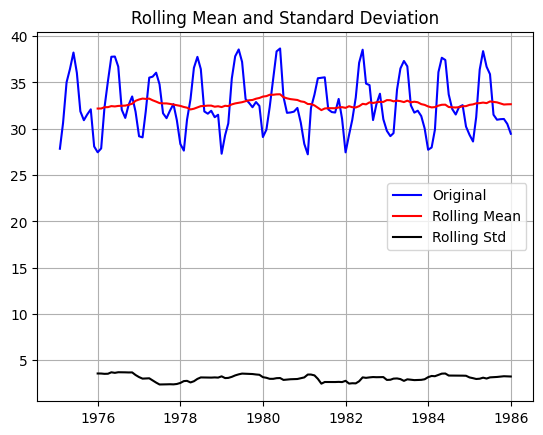

In [217]:
dftest(f75_85.MAX)


In [218]:
# Important to note that values have strong seasonality and adf test as well as rolling mean may not capture this.
# That is why it is always important to pay attention to run sequence plot
# f75_85['lag_12'] = f75_85.shift(12)
# f75_85['seasonal_diff'] = f75_85["MAX"] - f75_85['lag_12']

# fig,axes = plt.subplots(2,1)
# axes[0].plot(f75_85.MAX,label ='original')
# axes[1].plot(f75_85.seasonal_diff,label = 'seasonal diff')

In [219]:
# dftest(f75_85["seasonal_diff"].dropna())


In [220]:
# f75_85.reset_index(inplace=True)

In [221]:
# f75_85.head()

In [222]:
train = f75_85.iloc[:-12]
test = f75_85.iloc[-12:]

In [223]:
train.head(13)

,MAX
Date,
1975-01-31,27.845161
1975-02-28,30.628571
1975-03-31,35.016129
1975-04-30,36.460000
1975-05-31,38.235484
1975-06-30,36.041379
1975-07-31,31.880645
1975-08-31,30.925806
1975-09-30,31.553333


In [224]:
test.head(12)

,MAX
Date,
1985-01-31,28.625806
1985-02-28,31.253571
1985-03-31,36.387097
1985-04-30,38.386667
1985-05-31,36.700000
1985-06-30,35.896667
1985-07-31,31.519355
1985-08-31,30.977419
1985-09-30,31.036667


In [225]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaler_train = scaler.transform(train)
scaler_test = scaler.transform(test)

In [226]:
scaler_train.shape


(120, 1)

In [227]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


In [228]:
scaler_train[12]

array([0.0560832])

In [229]:
n_input = 12
generator = TimeseriesGenerator(scaler_train, scaler_train, length=n_input, batch_size=1)


In [230]:
print(type(generator))
generator[0]


<class 'keras.src.legacy.preprocessing.sequence.TimeseriesGenerator'>


(array([[[0.05303643],
         [0.29645591],
         [0.680164  ],
         [0.80643584],
         [0.96170845],
         [0.76982592],
         [0.40595437],
         [0.32245021],
         [0.37732975],
         [0.42513776],
         [0.07444848],
         [0.0194655 ]]]),
 array([[0.0560832]]))

In [231]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM , Dropout
from tensorflow.keras.utils import plot_model


In [232]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

C:\Users\dsmat\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [233]:
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

Model 2 low acc then above 

In [234]:
# model=Sequential()
# model.add(LSTM(100,return_sequences=True,input_shape=(12,1)))
# model.add(LSTM(50,return_sequences=True))
# model.add(LSTM(50))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error',optimizer='adam')


In [235]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

MODEL 3 good rmse with r2 = 0.85

In [236]:
model = Sequential()

# First LSTM layer with 128 neurons
model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(n_input, 1)))

# Second LSTM layer with 64 neurons
model.add(LSTM(64, activation='relu', return_sequences=True))

# Third LSTM layer with 32 neurons
model.add(LSTM(32, activation='relu'))

# Dropout for regularization
model.add(Dropout(0.2))

# Fully connected layer with 16 neurons
model.add(Dense(16, activation='relu'))

# Output layer
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 12, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 12, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,929 (503.63 KB)

 Trainable params: 128,929 (503.63 KB)

 Non-trainable params: 0 (0.00 B)

Model 4  rmse =0.9286180138677326 r2 = 0.91


In [237]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()

# First LSTM layer with 128 neurons
model.add(LSTM(128, activation='tanh', return_sequences=True, input_shape=(n_input, 1)))

# Second LSTM layer with 64 neurons (reduced depth for better stability)
model.add(LSTM(64, activation='tanh'))

# Dropout for regularization (slightly reduced)
model.add(Dropout(0.1))

# Fully connected layer with 32 neurons
model.add(Dense(32, activation='relu'))

# Output layer
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 12, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,081 (461.25 KB)

 Trainable params: 118,081 (461.25 KB)

 Non-trainable params: 0 (0.00 B)

In [187]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file="model_plot.png")


You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [188]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)


In [189]:
model.fit(generator,epochs=100,callbacks=[early_stop])

Epoch 1/100
 59/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1743

C:\Users\dsmat\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1391
Epoch 2/100
 61/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0804

C:\Users\dsmat\AppData\Roaming\Python\Python311\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0783
Epoch 3/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0458
Epoch 4/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0410
Epoch 5/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0193
Epoch 6/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0237
Epoch 7/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0303
Epoch 8/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0174
Epoch 9/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0178
Epoch 10/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0143
Epoch 11/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0153
Epoch 12/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0190
Epoch 13/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0158
Epoch 14/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0112
Epoch 15/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0148
Epoch 16/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

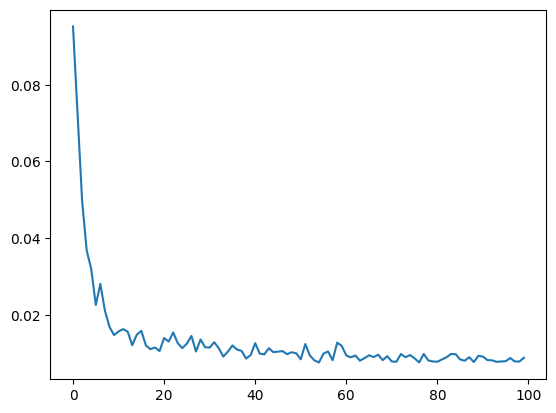

In [190]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
model.save('lstm_4_layer.h5')

In [191]:
last_train_batch = scaler_train[-12:]


In [192]:
last_train_batch = last_train_batch.reshape((1, n_input, 1))


In [193]:
model.predict(last_train_batch)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


array([[0.14074787]], dtype=float32)

In [194]:
scaler_test[0]


array([0.12130673])

In [239]:
from tensorflow.keras.models import load_model
model = load_model('lstm_4_layer.h5', compile=False)  

## This prediction is for year 85

In [240]:
test_predictions = []

first_eval_batch = scaler_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, 1))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [241]:
test_predictions

[array([0.11387923], dtype=float32),
 array([0.41747713], dtype=float32),
 array([0.6581059], dtype=float32),
 array([0.8477123], dtype=float32),
 array([0.872773], dtype=float32),
 array([0.7069387], dtype=float32),
 array([0.45086747], dtype=float32),
 array([0.37102026], dtype=float32),
 array([0.40408915], dtype=float32),
 array([0.371159], dtype=float32),
 array([0.18537535], dtype=float32),
 array([0.09983676], dtype=float32)]

In [242]:
test.head()

,MAX
Date,
1985-01-31,28.625806
1985-02-28,31.253571
1985-03-31,36.387097
1985-04-30,38.386667
1985-05-31,36.700000


In [243]:
true_predictions = scaler.inverse_transform(test_predictions)


In [244]:
test['Predictions'] = true_predictions


C:\Users\dsmat\AppData\Local\Temp\ipykernel_27404\2515899287.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<Axes: xlabel='Date'>

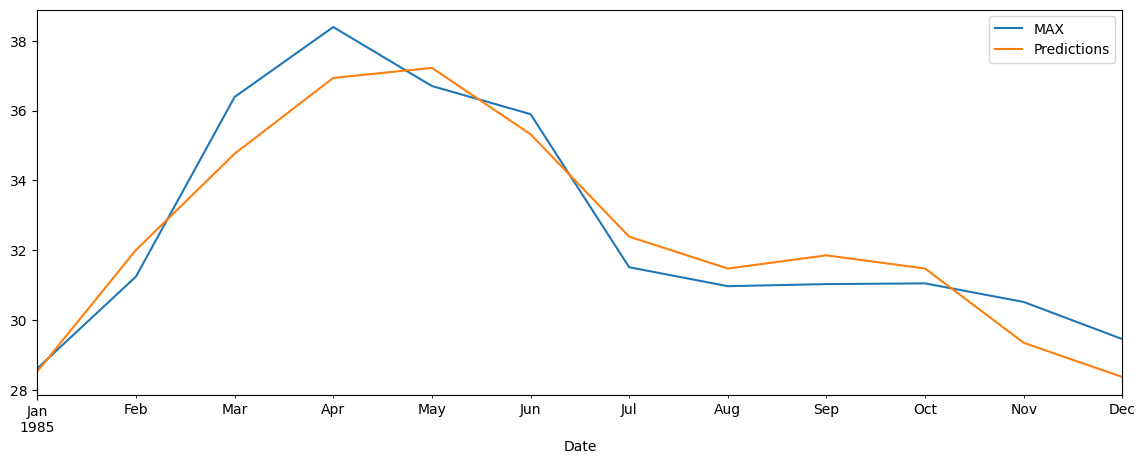

In [245]:
test.plot(figsize=(14,5))


In [246]:

from sklearn.metrics import mean_squared_error
from math import sqrt



In [247]:
from sklearn.metrics import r2_score
r2_score(test['MAX'],test['Predictions'])


0.9106654181426298

taken 1985 and predict usign sliding and got apporimate 11 year correct 

Prediction With rmse and r2 for year 86

In [248]:
test_predictions_86 = []


for i in range(12):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch, verbose=0)[0]
    
    # append the prediction into the array
    test_predictions_86.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
true_predictions = scaler.inverse_transform(test_predictions_86)
test_86 = f86_96.iloc[:12].copy()
test_86['Predictions'] = true_predictions
rmse=sqrt(mean_squared_error(test_86['MAX'],test_86['Predictions']))
print(rmse)
r2 =r2_score(test_86['MAX'],test_86['Predictions'])
print(r2)

0.8881708556204252
0.9039182809632086


from year 87 to 96

In [249]:
k = 87 
for j in range(12 , 120 , 12) :
    test_predictions = []

    
    for i in range(12):
    
        # get the prediction value for the first batch
        current_pred = model.predict(current_batch,verbose=0)[0]

        # append the prediction into the array
        test_predictions.append(current_pred) 

        # use the prediction to update the batch and remove the first value
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    true_predictions = scaler.inverse_transform(test_predictions)
    test_ = f86_96.iloc[j:j+12].copy()
    test_['Predictions'] = true_predictions
    print(f" r2 & RMSE for {k} year: ")
    rmse=sqrt(mean_squared_error(test_['MAX'],test_['Predictions']))
    
    r2 =r2_score(test_['MAX'],test_['Predictions'])
    print(f'{r2} , {rmse}')
    k += 1
    

 r2 & RMSE for 87 year: 
0.8734204141811595 , 1.125177653576717
 r2 & RMSE for 88 year: 
0.770434404846042 , 1.13438246933723
 r2 & RMSE for 89 year: 
0.840185826170081 , 1.1883438715418053
 r2 & RMSE for 90 year: 
-0.6330147763678642 , 2.036934074070576
 r2 & RMSE for 91 year: 
0.9591157417494056 , 0.7128454472725492
 r2 & RMSE for 92 year: 
0.8234423082457706 , 1.133520349584155
 r2 & RMSE for 93 year: 
0.7773978907461829 , 1.1687582617932306
 r2 & RMSE for 94 year: 
0.7881512399523133 , 1.3666882076504092
 r2 & RMSE for 95 year: 
0.7369608375787092 , 1.4438092487373029


In [143]:
f96_05 = monthly_data['1996-01-01':'2006-01-01']
current_batch= scaler.transform(f96_05.iloc[:12])
current_batch = current_batch.reshape((1, n_input, 1))

By taking 1986 data able to get next 7 year prediction with high r2 score 

In [144]:
k = 1997
for j in range(12, 120 , 12) :
    test_predictions = []

    
    for i in range(12):
    
        # get the prediction value for the first batch
        current_pred = model.predict(current_batch,verbose=0)[0]

        # append the prediction into the array
        test_predictions.append(current_pred) 

        # use the prediction to update the batch and remove the first value
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    true_predictions = scaler.inverse_transform(test_predictions)
    test_ = f96_05.iloc[j:j+12].copy()
    test_['Predictions'] = true_predictions
    print(f" r2 & RMSE for {k} year: ")
    test_['MAX'] = test_['MAX'].fillna(0)
    rmse=sqrt(mean_squared_error(test_['MAX'],test_['Predictions'])) 

    r2 =r2_score(test_['MAX'],test_['Predictions'])
    print(f'{r2} , {rmse}')
    k += 1
    

 r2 & RMSE for 1997 year: 
0.8168539925882365 , 1.1302223952822108
 r2 & RMSE for 1998 year: 
0.9610496918829099 , 0.582912930604786
 r2 & RMSE for 1999 year: 
0.7670115697076738 , 1.5277957766663346
 r2 & RMSE for 2000 year: 
0.7385354130211987 , 1.2845896807978952
 r2 & RMSE for 2001 year: 
0.0 , 32.72069004166578
 r2 & RMSE for 2002 year: 
0.8559094542579513 , 1.130758081469951
 r2 & RMSE for 2003 year: 
0.9001533452393623 , 1.1353152900003298
 r2 & RMSE for 2004 year: 
0.8226101957139689 , 1.3023021038864147
 r2 & RMSE for 2005 year: 
0.8230767950430884 , 1.3389677596101839


In [141]:
f06_15 = monthly_data['2006-01-01':'2016-01-01']

In [142]:
k = 2006
for j in range(0, 120 , 12):
    test_predictions = []

    
    for i in range(12):
    
        # get the prediction value for the first batch
        current_pred = model.predict(current_batch,verbose=0)[0]

        # append the prediction into the array
        test_predictions.append(current_pred) 

        # use the prediction to update the batch and remove the first value
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    true_predictions = scaler.inverse_transform(test_predictions)
    test_ = f06_15.iloc[j:j+12].copy()
    test_['Predictions'] = true_predictions
    print(f" r2 & RMSE for {k} year: ")
    test_['MAX'] = test_['MAX'].fillna(0)
    rmse=sqrt(mean_squared_error(test_['MAX'],test_['Predictions'])) 

    r2 =r2_score(test_['MAX'],test_['Predictions'])
    print(f'{r2} , {rmse}')
    k += 1
    

 r2 & RMSE for 2006 year: 
0.584642217580857 , 1.4966779563978645
 r2 & RMSE for 2007 year: 
0.6271428679978238 , 1.471725511069337
 r2 & RMSE for 2008 year: 
0.4682117458188304 , 1.7970875242156794
 r2 & RMSE for 2009 year: 
0.5694264885040665 , 2.0200070827076493
 r2 & RMSE for 2010 year: 
0.8066132013884844 , 1.5031678999271065
 r2 & RMSE for 2011 year: 
0.0 , 32.7336095900186
 r2 & RMSE for 2012 year: 
0.6096266494256706 , 2.192287923968006
 r2 & RMSE for 2013 year: 
0.7520554733728618 , 1.7230464638543255
 r2 & RMSE for 2014 year: 
0.5098965693883445 , 2.6366826674011943
 r2 & RMSE for 2015 year: 
0.028410554492683593 , 9.611745019489556
